Cortex+MD model. THis notebook is meant to have the experiments of generalizing behavior to other contexts showing histograms from specific examples, and also the switch dynamics experiment for the RNN+MD_Cxt model and RNN+MD_cxt_var model. 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
import tasks.generative_1d
from tasks.generative_1d import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.3
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]



# Thalamocortical+Context

In [3]:
config = Config()
scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':40}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
train_steps = int(100 * scale)
logger = Logger(config)
logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon =5

_use_oracle = True
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

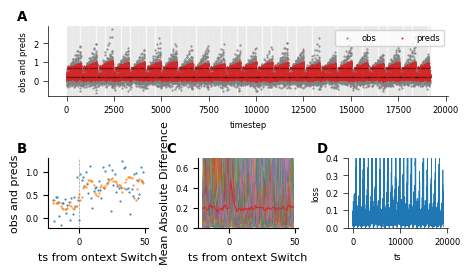

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

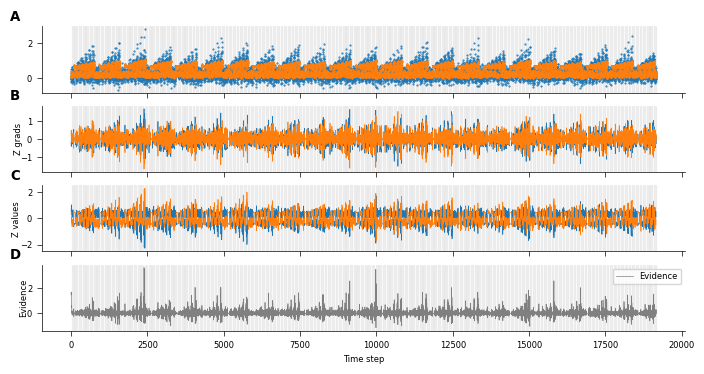

In [4]:
# Run switching experiment on RNN _ MD context model 
def run_exp_switching_RNN_Cxt(model, _use_optimized_thalamus=False):
    _use_oracle = False
    
    config= Config(context_units=2)
    scale = 30

    config.capture_variance_experiment = False
    # config.capture_variance_experiment = capture_variance_experiment
    if config.capture_variance_experiment:
            config.output_size = 2
            # criterion = criterion_var_scaled
            criterion = mse_ignore_var
    else:
            config.output_size = 1
            criterion = nn.MSELoss(reduction='sum')

    training_phase_1_config = {'context_transition_function':'base_block_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 16*20}
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    logger.experiment_name = f'quantifying_generalization_{_use_oracle}'

    env = Generative_environment(config, experiment=6, novel_mean=default_mean2) # it will use the novel_mean as the mean of the second gaussian
    horizon =5
    config.l2_loss = 0.03
    # optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=0.05,   ) #lr=.20, weight_decay=0.01)
    # SGD optimizer
    optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.20, momentum=0.5)
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    if _use_optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env


memory_buffer_RNN_cxt,  losses_RNN_cxt , env_RNN_cxt= run_exp_switching_RNN_Cxt(model, _use_optimized_thalamus=True)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

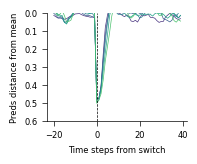

In [5]:
switch_triggered_distance_from_mean_cxt = extract_per_std_distance_from_mean(memory_buffer_RNN_cxt, env_RNN_cxt, ts_before=20, ts_after=40)

fig, axes = plt.subplots(1, 1, figsize=(1.8, 1.4), dpi=100)
ax = axes
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt, ax)
# plt.savefig('./exports/switching_thalamocortical_cxt.pdf', )

# Thalamocortical + cxt + var
Repeat the same experiments as above, but expand to a model with 4 MD neurons, 2 for context input and 2 for variance. 

In [6]:
# config = Config()
scale = 20 ###############################################################################################################################
# config = Config(env_kwargs= { 'gauss1': {'mean': 0.3, 'std': 0.3}, 'gauss2': {'mean': 0.7, 'std': 0.1}, 'gauss3': {'mean': 0.3, 'std': 0.1}}, context_units=4)
# config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': 0.1, 'std': 0.3}, 'gauss2': {'mean': 0.9, 'std': 0.1}, 'gauss3': {'mean': 0.1, 'std': 0.1}}, context_units=4)
config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': 0.2, 'std': 0.3}, 'gauss2': {'mean': 0.8, 'std': 0.1}, 'gauss3': {'mean': 0.2, 'std': 0.1}, 'gauss4': {'mean': 0.8, 'std': 0.3}}, context_units=4)

default_mean1 = 0.2
default_mean2 = 0.8
default_std = 0.1

# rewrite config but with the new default mean
config.env_kwargs['gauss1']['mean'] = default_mean1
config.env_kwargs['gauss2']['mean'] = default_mean2
config.env_kwargs['gauss3']['mean'] = default_mean1
config.env_kwargs['gauss4']['mean'] = default_mean2

# config = generalization_mean_and_var_Config ( context_units=4)
# config.context_signal_type = 'compositional'
adam_l2_loss = 0.08 # not really effectively used.
ablate_context = False

In [7]:
def mse_ignore_var(output, target):
    mu = output[..., :1]
#     sigma = output[..., 1:]
    z = F.mse_loss(mu, target, reduction='none')#/sigma
    total_loss = torch.sum(z) #+ alpha * torch.sum(sigma)
    return total_loss

def criterion_var_scaled(output, target):
    mu = output[..., :1]
    sigma = output[..., 1:]
    # variance modulated loss:
    z = F.mse_loss(mu, target, reduction='none')/sigma
    alpha = 0.3
    total_loss = torch.sum(z) + alpha * torch.sum(sigma)

    return total_loss

def criterion_gaussian_log_likelihood(output, target):
    mu = output[..., :1]
    sigma = output[..., 1:]
    # Compute the negative log-likelihood of the target values under the predicted Gaussian distribution
    log_likelihood = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) - 0.5 * ((target - mu)** 2 / sigma**2) 
    # Compute the mean negative log-likelihood over the batch
    mean_log_likelihood = torch.mean(log_likelihood)
    return (-mean_log_likelihood)


config.ablate_context_signal = ablate_context
capture_variance_experiment = True
config.capture_variance_experiment = capture_variance_experiment
if config.capture_variance_experiment:
        config.output_size = 2
        criterion = criterion_gaussian_log_likelihood

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

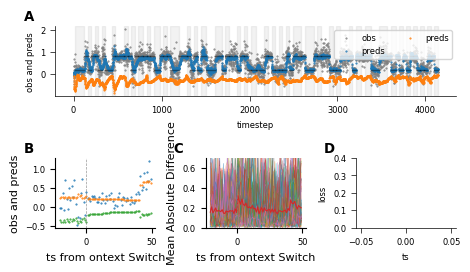

In [8]:
config.context_signal_type = 'compositional'
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 
         'no_of_blocks': 80 } 
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=1,)# novel_mean=0.7, novel_std=0.3)
model_RNN_cxt_var = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model_RNN_cxt_var.parameters(), lr=0.001)
ts_in_training= 0
horizon = 7
config.l2_loss = False
_use_oracle = True
memory_buffer, losses = adapt_model_v2(model_RNN_cxt_var, env, _use_oracle, config, WU_optimizer, horizon, criterion, ts_in_training, logger)
plot_behavior(memory_buffer, env, losses, config, _use_oracle )

model = model_RNN_cxt_var

In [9]:
debugging = False
# debugging = False
#Test generalization:
def run_exp_switching_RNN_Cxt_var(model, _use_optimized_thalamus=False, lr = None, momentum = None, gradient_clipping = None, l2_loss = None, use_adam_optimizer = False):
    _use_oracle = False
    
    config= Config(context_units=4)
    scale = 60
    if debugging:
        config.default_mean1 = 0.35
        config.default_mean2 = 0.65
        config.default_std = 0.1 # lower to make the base context switching to easier
    else:
        config.default_mean1 = default_mean1
        config.default_mean2 = default_mean2
        config.default_std = 0.1 # lower to make the base context switching to easier

    config.capture_variance_experiment = True
    # config.capture_variance_experiment = capture_variance_experiment
    if config.capture_variance_experiment:
            config.output_size = 2
            # criterion = criterion_var_scaled
            criterion = mse_ignore_var
            # criterion = criterion_gaussian_log_likelihood
    else:
            config.output_size = 1
            criterion = nn.MSELoss(reduction='sum')

    if debugging:
        training_phase_1_config = {'context_transition_function':'base_block_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*20}
    else:
        training_phase_1_config = {'context_transition_function':'base_block_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 16*20}
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    logger.experiment_name = f'quantifying_generalization_{_use_oracle}'
    if debugging:
        env = Generative_environment(config, experiment=6, novel_mean=config.default_mean2) # it will use the novel_mean as the mean of the second gaussian
    else:
        env = Generative_environment(config, experiment=6, novel_mean=default_mean2)
    horizon =7
    if lr is None:
        lr = 0.2
    if momentum is None:
        momentum = 0.1
    if l2_loss is None:
        l2_loss = 0.03
    if gradient_clipping is None:
        gradient_clipping = 0

    config.l2_loss = l2_loss
    config.gradient_clipping = gradient_clipping
    if use_adam_optimizer:
        optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=lr,   ) #lr=.20, weight_decay=0.01)
    else:
        optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr= lr, momentum=momentum  ) #lr=.20, weight_decay=0.01)

    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    # plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    # if _use_optimized_thalamus: plot_grads(memory_buffer, env, )
    return memory_buffer, losses, env

# Some deterministic contexts for plotting:
def run_exp_generalization_behavior_metrics_RNN_cxt_var(model, _use_optimized_thalamus=False, lr = None, momentum = None, gradient_clipping = None, l2_loss = None, use_adam_optimizer = False):
    _use_oracle = False
    default_mean1 = 0.3
    default_mean2 = 0.7
    default_std = 0.3
    # config= Config(env_kwargs= { 'gauss1': {'mean': 0.2, 'std': 0.2}, 'gauss2': {'mean': 0.8, 'std': 0.2}, 'gauss3': {'mean': 1.1, 'std': 0.2}, 'gauss4': {'mean': 0.8, 'std': 0.5}}, context_units=4)
    # config= Config(env_kwargs= { 'gauss1': {'mean': 0.1, 'std': 0.2}, 'gauss2': {'mean': 0.2, 'std': 0.2}, 'gauss3': {'mean': 0.5, 'std': 0.2}, 'gauss4': {'mean': 0.6, 'std': 0.2}}, context_units=4)
    # config= Config(env_kwargs= { 'gauss1': {'mean': 0.1, 'std': 0.2}, 'gauss2': {'mean': 0.2, 'std': 0.2}, 'gauss3': {'mean': 0.4, 'std': 0.2}, 'gauss4': {'mean': 0.5, 'std': 0.2},
    #                              'gauss5': {'mean': 0.8, 'std': 0.2}, 'gauss6': {'mean': 0.8, 'std': 0.5}, 'gauss7': {'mean': 0.7, 'std': 0.2},}, context_units=4)
    config= Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},
                                 'gauss3': {'mean': default_mean1+0.1, 'std': default_std}, 'gauss4': {'mean': default_mean2, 'std': 0.5},
                                 'gauss5': {'mean': 0.5, 'std': default_std}}, context_units=4)
    scale = 1000 # use more data for histograms
    # scale = 100 # can use a quicker simulation for plotting behavior.

    config.capture_variance_experiment = True
    # config.capture_variance_experiment = capture_variance_experiment
    if config.capture_variance_experiment:
            config.output_size = 2
            # criterion = criterion_var_scaled
            criterion = mse_ignore_var
            # criterion = criterion_gaussian_log_likelihood
    else:
            config.output_size = 1
            criterion = nn.MSELoss(reduction='sum')

    training_phase_1_config = {'context_transition_function':'sequential',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 12}
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    env = Generative_environment(config, experiment=1, novel_mean=0.7) # it will use the novel_mean as the mean of the second gaussian
    horizon =5
    if lr is None:
        lr = 0.2
    if momentum is None:
        momentum = 0.1
    if l2_loss is None:
        l2_loss = 0.03
    if gradient_clipping is None:
        gradient_clipping = 0

    config.l2_loss = l2_loss
    config.gradient_clipping = gradient_clipping
    if use_adam_optimizer:
        optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=lr,   ) #lr=.20, weight_decay=0.01)
    else:
        optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr= lr, momentum=momentum  ) #lr=.20, weight_decay=0.01)

    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    
    # plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    # if _use_optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env

def run_exp_generalization_space_RNN_cxt_var(model, _use_optimized_thalamus=False, novel_std=0.1, lr = None, momentum = None, gradient_clipping = None, l2_loss = None, use_adam_optimizer = False):
    _use_oracle = False
    # config = generalization_mean_and_var_Config (context_units=4)
    config= Config(context_units=4)
    scale = 20
    config.capture_variance_experiment = True
    # config.capture_variance_experiment = capture_variance_experiment
    if config.capture_variance_experiment:
            config.output_size = 2
            # criterion = criterion_var_scaled
            criterion = mse_ignore_var
            # criterion = criterion_gaussian_log_likelihood
    else:
            config.output_size = 1
            criterion = nn.MSELoss(reduction='sum')

    training_phase_1_config = {'context_transition_function':'fixed_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*15} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    means = np.array(list(range(-2, 13)))/10
    env = Generative_environment(config, experiment=3, novel_std=novel_std)
    horizon = 7
    if lr is None:
        lr = 0.2
    if momentum is None:
        momentum = 0.1
    if l2_loss is None:
        l2_loss = 0.03
    if gradient_clipping is None:
        gradient_clipping = 0

    config.l2_loss = l2_loss
    config.gradient_clipping = gradient_clipping
    if use_adam_optimizer:
        optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=lr,   ) #lr=.20, weight_decay=0.01)
    else:
        optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr= lr, momentum=momentum  ) #lr=.20, weight_decay=0.01)

    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    # plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    # if _use_optimized_thalamus: plot_grads(memory_buffer, env, )
    return memory_buffer, losses, env

In [10]:
def run_gen_exp(model, l2_loss=0.06):
    memory_buffers_RNN_cxt_var = []
    losseses_RNN_cxt_var = []
    envs_RNN_cxt_var = []
    for std in stds:
        memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_generalization_space_RNN_cxt_var(model, _use_optimized_thalamus=True, novel_std=std,
        use_adam_optimizer=True, lr=0.2, l2_loss=l2_loss)
        # lr = 0.1, momentum = 0.1, gradient_clipping = 0, l2_loss = 0.03)
        # )
        memory_buffers_RNN_cxt_var.append(memory_buffer_RNN_cxt_var)
        losseses_RNN_cxt_var.append(losses_RNN_cxt_var)
        envs_RNN_cxt_var.append(env_RNN_cxt_var)

    # fig.savefig('./exports/quantifiying_generalization_Cxt_VAR.pdf', dpi=300)
    fig, axes = plt.subplots(1,1,figsize = [5/2.53, 4.5/2.53])
    plot_all_generalization_lines(memory_buffers_RNN_cxt_var , envs_RNN_cxt_var, axes, title='RNN cxt var', stds=stds, means=means)
    axes.set_xlim(-0.2, 1.2)
    axes.set_ylim(-0.2, 1.2)
    axes.set_title(f'l2_loss={l2_loss}')
    
# for l2 in [0.01, 0.03, 0.04, 0.06, 0.08, 0.1]:
sweep_params = False
if sweep_params:
    for l2 in [0.04, 0.06]:
        run_gen_exp(model, l2)
        plt.show()

#### Experimenting with optimization technique

In [11]:
# default_mean2 -= 0.1
# default_mean1 += 0.1

In [12]:
_use_optimized_thalamus = True
_use_oracle = False

config= Config(context_units=4)
scale = 40

config.default_mean1 = default_mean1

config.default_mean2 = default_mean2
config.default_std = 0.1 # lower to make the base context switching to easier

config.capture_variance_experiment = True
# config.capture_variance_experiment = capture_variance_experiment
if config.capture_variance_experiment:
        config.output_size = 2
        # criterion = criterion_var_scaled
        # criterion = mse_ignore_var
        criterion = criterion_gaussian_log_likelihood
else:
        config.output_size = 1
        criterion = nn.MSELoss(reduction='sum')

training_phase_1_config = {'context_transition_function':'base_block_alternating',
    'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
    'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 7*4}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
logger.experiment_name = f'quantifying_generalization_{_use_oracle}'

env = Generative_environment(config, experiment=6, novel_mean=default_mean2) # it will use the novel_mean as the mean of the second gaussian
horizon =7
config.l2_loss = 0.03
config.gradient_clipping = 0
optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=0.1,   ) #lr=.20, weight_decay=0.01)betas= (0.90, 0.99)
# optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=0.2, momentum=0.1  ) #lr=.20, weight_decay=0.01)

memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
    ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
# plot_behavior(memory_buffer, env, losses, config, _use_oracle )
# if _use_optimized_thalamus: plot_grads(memory_buffer, env, )
# plot_grads(memory_buffer, env,x1=1000, x2=2000)

In [13]:
memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_switching_RNN_Cxt_var(model, _use_optimized_thalamus=True
, use_adam_optimizer=True, lr=0.2, l2_loss=0.03)
                                # , lr = 0.3, momentum = 0.1, gradient_clipping = 0, l2_loss = 0.06)


(-10.0, 20.0)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

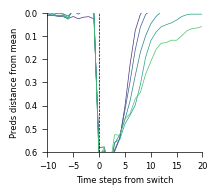

In [14]:
switch_triggered_distance_from_mean_cxt_var = extract_per_std_distance_from_mean(memory_buffer_RNN_cxt_var, env_RNN_cxt_var, ts_before=20, ts_after=40)
# now for each std plot the mean of the distance from the mean
fig, axes = plt.subplots(1, 1, figsize=(2., 1.8), dpi=100)
ax = axes
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt_var, ax)
ax.set_xlim(-10, 20)
# ax.set_ylim(-0.6, 0)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

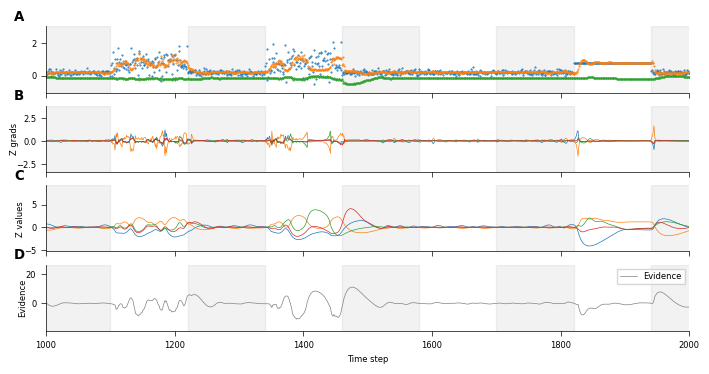

In [15]:
x1 = 1000
x2 = 2000
plot_grads(memory_buffer_RNN_cxt_var, env_RNN_cxt_var, x1=x1, x2=x2)

In [16]:
mn_behavior_RNN_cxt_var,  _ , env_behavior_RNN_cxt_var= run_exp_generalization_behavior_metrics_RNN_cxt_var(model, _use_optimized_thalamus=True,
# use_adam_optimizer=True, lr=0.05, l2_loss=0.061)
                                            lr = 0.012, momentum = 0.3, gradient_clipping = 0, l2_loss = 0.03)
# )
# plt.savefig('./exports/behavior_RNN.pdf')


env_id is larger than thalamus size, setting it to thalamus size-1


: 

: 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

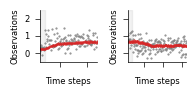

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

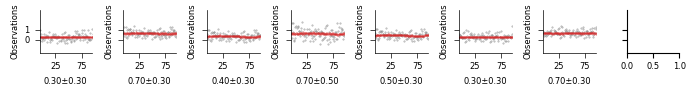

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

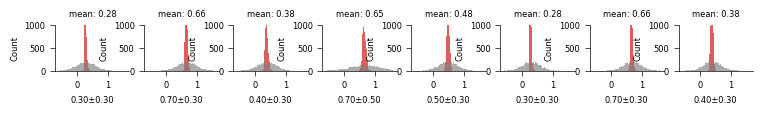

In [ ]:


plot_behavior_novel_contexts(mn_behavior_RNN_cxt_var, env_behavior_RNN_cxt_var, fig_height=1.)
plt.savefig('./exports/behavior_RNN_cxt_var.pdf')
plot_histograms_novel_contexts(mn_behavior_RNN_cxt_var, env_behavior_RNN_cxt_var, fig_height=.6)
plt.savefig('./exports/histograms_RNN_cxt_var.pdf')


/rdma/vast-rdma/vast-home/ahummos/code/contextual_switching_task/plot_functions.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(['', '25', '75'])
/rdma/vast-rdma/vast-home/ahummos/code/contextual_switching_task/plot_functions.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(['', '25', '75'])
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont

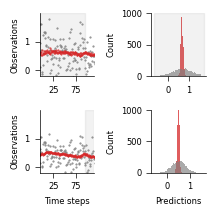

In [ ]:
plot_combined_behavior_and_histograms(mn_behavior_RNN_cxt_var, env_behavior_RNN_cxt_var, fig_height=2.2)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

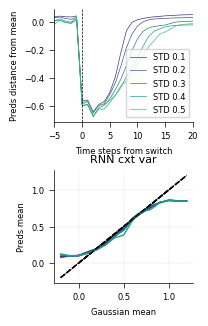

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


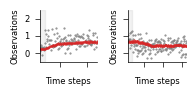

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

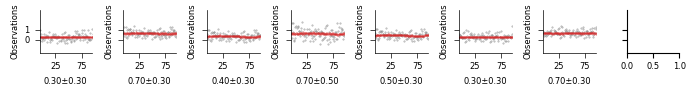

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

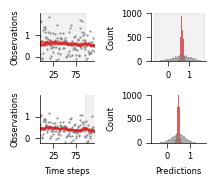

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

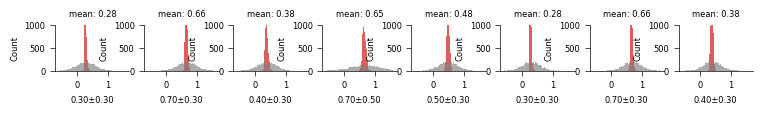

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=[5.4/2.53, 8/2.53], dpi=100)
ax = axes[0]
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt_var, ax)
ax = axes[1]
fig.tight_layout()
plot_behavior_novel_contexts(mn_behavior_RNN_cxt_var, env_behavior_RNN_cxt_var, fig_height=1.)
# plt.savefig('./exports/behavior_RNN_cxt_var.pdf')
plot_combined_behavior_and_histograms(mn_behavior_RNN_cxt_var, env_behavior_RNN_cxt_var, fig_height=1.9)
# plt.savefig('./exports/combined_behavior_histograms_RNN_cxt_var.pdf')
plot_histograms_novel_contexts(mn_behavior_RNN_cxt_var, env_behavior_RNN_cxt_var, fig_height=.6)

NameError: name 'switch_triggered_distance_from_mean_cortex' is not defined

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

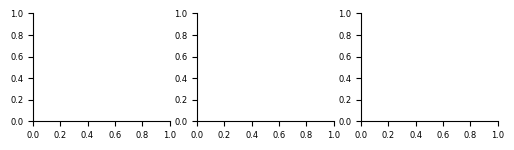

In [ ]:
# create a 3 x 1 plot with the 3 different models titled 'Cortex only', 'Cortex+MD Cxt', 'Cortex+MD Cxt STD'
# for each plot the switch triggered distance from mean
fig, axes = plt.subplots(1, 3, figsize=(6., 1.4), dpi=100)
ax = axes[0]
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cortex, ax, params='Cortex only', )
ax = axes[1]
folder_name = './exports/'
switch_triggered_distance_from_mean_cxt_var2 = np.load(folder_name + 'old_switch_triggered_distance_from_mean_cxt_var.npy', allow_pickle=True).item()
# plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt, ax, params='Cortex+MD Cxt')
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt_var2, ax, params='Cortex+MD Cxt+Var')

ax = axes[2]
# plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt_var2, ax, params='Cortex+MD Cxt+Var', )
# plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cortex, ax, params='Cortex only', cmap=plt.cm.inferno)
axes[1].legend().remove()
axes[2].legend().remove()
# axes[1].legend(loc='lower right', fontsize=6, ncol=1)
# set legend of axes[0] to be outside the subplot
axes[0].legend(loc='lower right', fontsize=6, ncol=1)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=1)

plt.tight_layout()
# plt.savefig('./exports/switching_thalamocortex_comparison2.pdf', )


NameError: name 'switch_triggered_distance_from_mean_cxt_var' is not defined

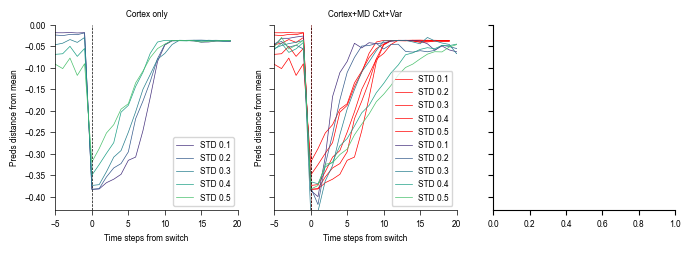

In [ ]:
# create a 3 x 1 plot with the 3 different models titled 'Cortex only', 'Cortex+MD Cxt', 'Cortex+MD Cxt STD'
# for each plot the switch triggered distance from mean

fig, axes = plt.subplots(1, 3, figsize=(8., 2.4), dpi=100,sharey=True)
ax = axes[0]
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cortex, ax, params='Cortex only')
ax = axes[1]
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cortex, ax, params='Cortex only')
# change the color map from viridis to something else
for line in ax.get_lines():
    line.set_color('r')
    
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt_var2, ax, params='Cortex+MD Cxt+Var')
# plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt, ax, params='Cortex+MD Cxt')
ax = axes[2]
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cxt_var, ax, params='Cortex+MD Cxt+Var')
axes[0].legend().remove()
axes[2].legend().remove()
axes[1].legend().remove()
# axes[1].legend(loc='lower right', fontsize=6, ncol=1)
plt.tight_layout()
# plt.savefig('./exports/switching_thalamocortex_comparison.pdf', )


In [ ]:
len(switch_triggered_distance_from_mean_cxt_var2[0.1])

23

In [ ]:
# save to disk switch_triggered_distance_from_mean_cortex, switch_triggered_distance_from_mean_cxt, switch_triggered_distance_from_mean_cxt_var

# folder_name = './exports/'
# np.save(folder_name + 'switch_triggered_distance_from_mean_cortex.npy', switch_triggered_distance_from_mean_cortex)
# np.save(folder_name + 'switch_triggered_distance_from_mean_cxt.npy', switch_triggered_distance_from_mean_cxt)
# np.save(folder_name + 'switch_triggered_distance_from_mean_cxt_var.npy', switch_triggered_distance_from_mean_cxt_var)

# load from disk

# folder_name = './exports/'

# switch_triggered_distance_from_mean_cortex = np.load(folder_name + 'switch_triggered_distance_from_mean_cortex.npy', allow_pickle=True).item()

# switch_triggered_distance_from_mean_cxt = np.load(folder_name + 'switch_triggered_distance_from_mean_cxt.npy', allow_pickle=True).item()

# switch_triggered_distance_from_mean_cxt_var = np.load(folder_name + 'switch_triggered_distance_from_mean_cxt_var.npy', allow_pickle=True).item()

# saved set with 0.3 and 0.7
# np.save(folder_name + 'switch_triggered_distance_from_mean_cortex_7_3.npy', switch_triggered_distance_from_mean_cortex)
# np.save(folder_name + 'switch_triggered_distance_from_mean_cxt_7_3.npy', switch_triggered_distance_from_mean_cxt)
# np.save(folder_name + 'switch_triggered_distance_from_mean_cxt_var_7_3.npy', switch_triggered_distance_from_mean_cxt_var)


In [ ]:
if False:
    import gc

    # lrs = [0.4, 0.2,]
    lrs = [ 0.1, 0.4, ]
    momentums = [0.0, 0.1,  0.2, ]
    gradient_clippings = [0.0, 10.0]
    l2_losses = [0.03, 0.05, 0.2]
    total = len(lrs)*len(momentums)*len(gradient_clippings)*len(l2_losses)
    print(f'Total number of experiments: {total}')

    os.makedirs('./exports/var_grid2', exist_ok=True)

    for lr in lrs:
        for momentum in momentums:
            for gradient_clipping in gradient_clippings:
                for l2_loss in l2_losses:
                    memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_switching_RNN_Cxt_var(model, _use_optimized_thalamus=True, lr=lr, momentum=momentum, gradient_clipping=gradient_clipping, l2_loss=l2_loss)
                    plt.savefig(f'./exports/var_grid2/switching_lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}_behavior.png')
                    switch_triggered_distance_from_mean = extract_per_std_distance_from_mean(memory_buffer_RNN_cxt_var, env_RNN_cxt_var, ts_before=20, ts_after=40)
                    fig, axes = plt.subplots(1, 1, figsize=(3., 2.8), dpi=140)
                    ax = axes
                    # also save to disk the switch triggered distance from mean

                    np.save(f'./exports/var_grid2/switch_triggered_distance_from_mean_lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}.npy', switch_triggered_distance_from_mean)
                    plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean, ax, params=f'lr={lr}, mom={momentum}, gc={gradient_clipping}, l2={l2_loss}')
                    plt.savefig(f'./exports/var_grid2/switching_lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}.png')
                    plt.close('all')
                    plt.clf()
                    plt.cla()
                    gc.collect()
                    torch.cuda.empty_cache()
                    print(f'lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}')
